## Dependencies
All modules and packages required for the project.

In [1]:
# Dependencies
import numpy as np
import pandas as pd
from enum import Enum
import random
import matplotlib.pyplot as plt

from util.ImageGeneration import *
from util.helper_functions import *

from collections import deque

## Task 2

In [2]:
# Softmax Regression - Task 2
class SoftmaxRegression:
    def __init__(self, X_train, y_train, X_test, y_test, X_val, y_val, lr, epsilon, regularization, seed):
        random.seed(seed)
        
        self.n = len(X_train)                                           # of training examples
        self.d = len(X_train[0])                                        # of features
        self.labels = 4                                                 # of classes (colors)
        self.X_train = X_train #np.c_[np.ones(self.n), X_train]         # Training data
        self.X_test = X_test                                            # Testing data
        self.X_val = X_val                                              # Validation data
        self.y_train = y_train                                          # Training classification Labels
        self.y_test = y_test                                            # Testing classification Labels
        self.y_val = y_val                                              # Validation classification Labels
        self.weights = np.zeros((self.labels, self.d))                  # Current parameters / weights with d rows
        self.lr = lr                                                    # Learning rate   
        self.epsilon = epsilon                                          # Early stopping difference
        self.regularization, self.Lambda, self.decay = regularization   # Type of regularization, penalty, and decay of the penalty

    # Helper methods 
    # dataset = 0 - train; 1 - val; 2 - test
    def dataset_picker(self, dataset = 0):
        if dataset == 0:
            return self.X_train, self.y_train
        elif dataset == 1:
            return self.X_test, self.y_test
        else:
            return self.X_val, self.y_val

    # Helper methods 
    def predict(self, inds=None, dataset = 0):
        """Compute h_w(x_i) for the provided weight values"""
        X, y = self.dataset_picker(dataset)
        if inds is None:
            inds = np.arange(len(X))

        # pred = []
        # for label in range(self.labels):
        #     dot_product = np.dot(X[inds], self.weights[label].T)
        #     pred.append(softmax(dot_product))

        # return np.array(pred)
        
        dot_product = np.dot(self.weights, X[inds].T)
        return softmax(dot_product)

    def loss(self, Y, P):
        """Compute the current value of average loss based on predictions"""
        buffer = 1e-15
        #print(Y.shape, P.shape)
        loss = np.mean(-Y.T * np.log(P + buffer))
        if self.regularization == 2:
            loss += np.sum(self.Lambda * np.square(self.weights))
        return loss
    
    def accuracy(self, gold_labels, preds):
        #print(preds.shape)
        pred_labels = self.get_pred_labels(preds)
        correct = [1 if np.array_equal(pred, gold) else 0 for pred, gold in zip(pred_labels.T, gold_labels)]
        count, total = sum(correct), len(correct)
        acc = round(count/total*100, 2)
        
        return acc, count, total
    
    def predict_loss_acc(self, inds=None, dataset=0):
        X, y = self.dataset_picker(dataset)
        preds = self.predict(inds, dataset)

        loss = self.loss(y, preds)
        acc, correct, total = self.accuracy(y, preds)
        
        return loss, acc
    
    def gd(self):
        """Run a single epoch of GD"""
        pass
    
    def sgd(self):
        """Run a single epoch of SGD"""
        # Shuffle data before each epoch
        indices_array = np.arange(len(self.X_train))
        random.shuffle(indices_array)
        
        for ind in indices_array:
            resid = self.y_train[ind] - self.predict(ind)
            resid = resid[:, np.newaxis]
            x_col = self.X_train[ind][:, np.newaxis].T
            # print(resid.shape, x_col.shape, self.weights.shape)
            gradient = -1 * np.matmul(resid, x_col)
            
            if self.regularization == 2:
                gradient += 2 * self.Lambda * self.weights
            self.weights -= self.lr * gradient

    # Stochastic Gradient Descent
    def train(self, epochs, display_steps = 1, stochastic=True):
        """Run SGD until # of epochs is exceeded OR convergence"""
        prev_loss = deque([float('inf')])
        prev_acc = deque([float('inf')])
        
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        print("Epoch\t\tTrainLoss\tValLoss\t\tTrainAcc\tValAcc")  
        for epoch in range(epochs):
            if stochastic:
                self.sgd()
            else: self.gd()

            loss_train, acc_train = self.predict_loss_acc(dataset=0)
            loss_val, acc_val = self.predict_loss_acc(dataset=2)
            
            self.train_losses.append(loss_train)
            self.val_losses.append(loss_val)
            self.train_accuracies.append(acc_train)
            self.val_accuracies.append(acc_val)
                        
            mean_loss = sum(prev_loss)/len(prev_loss)
            mean_acc = sum(prev_acc)/len(prev_acc)

            if epoch % display_steps == 0:
                print(f"{epoch}\t\t{round(loss_train, 3)}\t\t{round(loss_val, 3)}\t\t{acc_train}%\t\t{acc_val}%")
                #print(f"LOSS: {epoch} - train: {loss_train}; val: {loss_val}; mean: {mean_loss}")
                #print(f"ACC: {epoch} - train: {acc_train}; val: {acc_val}, mean: {mean_acc}")
            
            if abs(mean_loss - loss_val) < self.epsilon:
            #if abs(mean_acc - loss_val) < self.epsilon:
                print(f"Stopping early at epoch {epoch}")
                break
            prev_loss.append(float(loss_val))
            prev_acc.append(float(acc_val))
            if len(prev_loss) > 10:
                prev_loss.popleft()
            if len(prev_acc) > 10:
                prev_acc.popleft()

            self.Lambda *= self.decay
                
    # Model Evaluation
    def indicator(self, pred):
        """Returns label 1 if p(y == 1) > .5, 0 if p(y == 1) < .5, and breaks ties randomly"""
        max_ind = np.argmax(pred)
        one_hot = np.zeros_like(pred)
        one_hot[max_ind] = 1
        return one_hot
    
    def get_pred_labels(self, preds):
        """Converts prediction probabilities into labels"""
        for i in range(preds.shape[1]):
            #print(preds[:,i].shape, preds[:,i])
            preds[:,i] = self.indicator(preds[:,i])
            
        return preds

    def test(self):
        """Compute the accuracy of the models predictions for test and training data"""
        probs_train = self.predict(dataset=0)
        acc_train, correct_train, total_train = self.accuracy(self.y_train, probs_train)
        print(f"TRAINING ACCURACY: {acc_train}%, {correct_train}/{total_train}")
        
        probs_test = self.predict(dataset=1)
        acc_test, correct_test, total_test = self.accuracy(self.y_test, probs_test)
        print(f"TESTING ACCURACY: {acc_test}%, {correct_test}/{total_test}")

        plot_data(f"Loss In Relation to Epochs ({self.n} train samples)", "Epochs", "Loss", [(self.train_losses, "Train"), (self.val_losses, "Validation")])
        plot_data(f"Accuracy In Relation to Epochs ({self.n} train samples)", "Epochs", "Accuracy", [(self.train_accuracies, "Train"), (self.val_accuracies, "Validation")])


In [8]:
# Generate and Preprocess Data
data = DataSet()
SEED = 718067190
img_gen = ImageGenerator(1000, dataset = data, seed = SEED, task = 2)
image_data, _, third_wires = preprocess_data(data, "noraw")
image_data.shape

(1000, 809)

In [9]:
# Set hyperparameters and train Model
lr = .01
epsilon = .0005
Lambda, decay = .01, .6
EPOCH_LIM = 500
regularization = (2, Lambda, decay)
ttv_split = train_test_validation_split(image_data, third_wires) # train, test, and validation

softm = SoftmaxRegression(*ttv_split, lr, epsilon, regularization, seed = SEED)
sgd = softm.train(EPOCH_LIM)
predictions = softm.get_pred_labels(softm.predict())

Epoch		TrainLoss	ValLoss		TrainAcc	ValAcc
0		2.606		3.63		42.62%		25.0%
1		2.515		4.184		44.38%		26.0%
2		2.667		4.306		41.12%		26.0%
3		2.247		3.607		42.38%		19.0%
4		2.182		3.684		45.88%		27.0%
5		2.073		3.621		48.25%		27.0%
6		1.961		3.817		49.38%		31.0%
7		1.921		4.013		48.25%		21.0%
8		2.671		4.942		41.0%		20.0%
9		2.178		4.23		44.0%		17.0%
10		1.824		3.994		51.62%		27.0%
11		1.682		3.893		52.12%		27.0%
12		1.978		3.592		50.5%		27.0%
13		1.89		3.807		53.5%		27.0%
14		1.749		3.467		49.75%		30.0%
15		1.816		3.18		52.25%		30.0%
16		1.87		3.676		50.88%		26.0%
17		1.713		3.261		53.75%		33.0%
18		1.611		2.892		54.0%		36.0%
19		1.564		3.56		53.87%		27.0%
20		1.53		3.095		53.62%		36.0%
21		1.97		3.25		50.88%		34.0%
22		1.447		3.901		57.88%		29.0%
23		1.531		3.282		53.75%		32.0%
24		1.484		3.435		54.87%		29.0%
25		1.277		2.854		58.88%		36.0%
26		1.467		3.102		56.75%		39.0%
27		1.532		3.994		54.0%		25.0%
28		1.34		4.195		55.75%		25.0%
29		1.387		3.146		60.12%		40.0%
30		1.18		2.978		59.0%		

TRAINING ACCURACY: 90.25%, 722/800
TESTING ACCURACY: 40.0%, 40/100


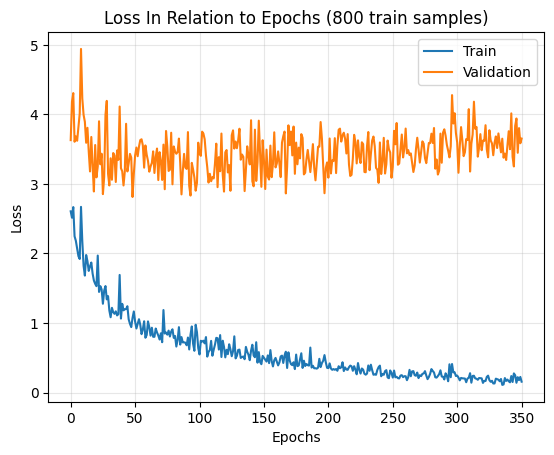

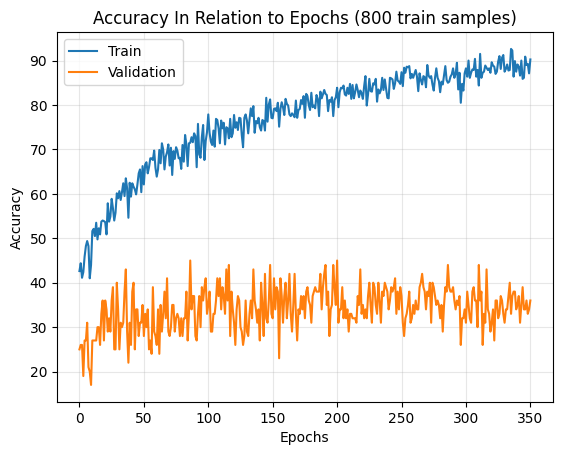

SUM OF WEIGHTS: [ 0.22051364  1.67750317  5.80983297  3.13825927  1.77628468  3.21063999
  3.3055605   4.48541622  0.42600989  3.33924796  0.63072158  2.23496996
  1.59385615  3.65781081  5.21209384  0.6544189   2.7330283   1.97158017
  0.80947678  5.10679222  2.04522487  3.42717934  3.47205545  3.96630186
  3.59921757  1.15813158  3.99354908  1.8767608   3.34329189  2.33872861
  1.01279508  3.95135155  1.56190655  4.6190504   2.63865559  1.99720178
  3.53608561  2.76646129  2.73965893  1.60155632  2.80876011  0.70594509
  3.26436574  0.66207295  3.19928533  4.63136381  4.77080367  1.23779159
  1.72694607  1.66537364  2.81585332  3.74197863  4.19535528  2.55171394
  0.98311963  2.51354907  5.2710952   1.81052114  2.48666706  3.53951562
  5.52689927  1.64524403  1.86798354  2.18360364  3.33295173  2.31166165
  2.40953766  2.15664937  2.48977104  3.59367188  3.52078717  1.26645601
  4.34968817  2.57503044  3.89363228  3.69689757  2.4858334   0.65971703
  2.12150872  3.67681831  3.6070190

In [10]:
softm.test()
print(f"SUM OF WEIGHTS: {sum(abs(softm.weights))}")

In [12]:
pred = softm.predict()
pred

array([[0.25, 0.25, 0.25, ..., 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, ..., 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, ..., 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, ..., 0.25, 0.25, 0.25]])